# **Support Vector Machine (SVM)**

Support Vector Machine (SVM) is a supervised machine learning algorithm used primarily for classification tasks, but it can also be applied to regression. SVM works by finding the hyperplane that best separates different classes in the feature space, maximizing the margin between data points of different classes.

#### Key Features:

-   **Classification**: SVM excels in binary and multi-class classification problems.
-   **Margin Maximization**: It tries to find the optimal hyperplane that maximizes the margin between different classes, which helps improve model generalization.
-   **Kernel Trick**: SVM can handle non-linear data by using kernel functions, transforming the feature space into a higher-dimensional space for better separation.
-   **Support Vectors**: The data points that are closest to the hyperplane are called support vectors, which are crucial in determining the optimal hyperplane.


### **Load the Dataset**

The dataset loaded contains 15 columns:

-   Columns 1 - 14: Features (These are the PC identified in during data cleaning and exploratory data analysis)
-   Column 15: Target (This is the column which will be eventually predicted by the model)


In [1]:
import pandas as pd

data = pd.read_csv("../../dataset/dataset_final.csv")

In [2]:
features = data.drop('Target', axis=1)
target = data['Target']

Value Counts for Target:
Target
Dropout     2209
Graduate    2209
Enrolled    2209
Name: count, dtype: int64


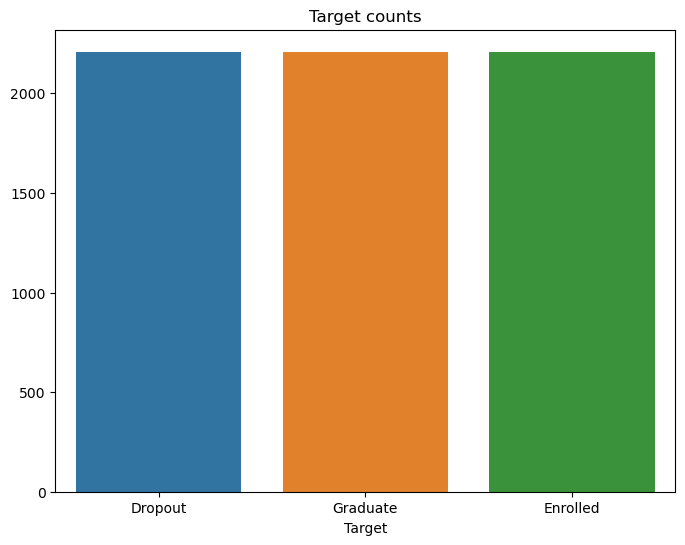

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

target_counts = target.value_counts()

print(f"Value Counts for Target:\n{target_counts}")
plt.figure(figsize=(8,6))
sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index)
plt.title('Target counts')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split 

def split_data(X, y, train_size, test_size, val_size=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=train_size, shuffle=True)
    if val_size is not None:
      X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, train_size=test_size/(test_size + val_size), shuffle=True)
      
      return X_train, X_test, X_val, y_train, y_test, y_val
    
    return X_train, X_test, pd.Series([]), y_train, y_test, pd.Series([])

X_train, X_test, X_val, y_train, y_test, y_val = split_data(features, target, 0.8, 0.2)
train = (X_train, y_train)
test = (X_test, y_test)
val = (X_val, y_val)

training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)
validation_data = pd.concat([X_val, y_val], axis=1)

# Check if the distribution is correct
total = features.shape[0]
print(f"Training data distribution {(training_data.value_counts().sum() / total):.0%}")
print(f"Testing data distribution {(testing_data.value_counts().sum() / total):.0%}")
print(f"Validation data distribution {(validation_data.value_counts().sum() / total):.0%}")

Training data distribution 80%
Testing data distribution 20%
Validation data distribution 0%


### **SVM Classification with Hyperparameter Tuning**

1. **Libraries Used**:

    - Support Vector Classifier (`SVC`) implemented using `scikit-learn`.
    - Hyperparameter Tuning with 5-fold Cross Validation is implemented using `GridSearchCV` (Exhaustive Search).

2. **Defining the SVM Model**:  
   An SVM classifier (`SVC`) is instantiated without any predefined hyperparameters.

3. **Hyperparameter Grid Setup**:  
   A grid of hyperparameters is defined for tuning the model:

    - `C`: Regularization strength. Higher values aim for a tighter fit.
    - `kernel`: The type of decision boundary (`linear`, `rbf`, `poly`).
    - `gamma`: Kernel coefficient for non-linear kernels.
    - `degree`: Degree of the polynomial kernel (used only when `kernel='poly'`).

4. **Testing the Model**:
    - The model is evaluated on the test set using the best-performing model found during training.
    - `accuracy_score` and `classification_report` summarize performance metrics, including precision, recall, and F1-score for each class.


In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_model = SVC()

# Define the grid of hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],               # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernels for SVM
    'gamma': ['scale', 'auto'],           # Kernel coefficient for 'rbf' and 'poly'
    'degree': [2, 3, 4]                   # Degree for the polynomial kernel
}

grid_search = GridSearchCV(
  estimator=svm_model, 
  param_grid=param_grid, 
  scoring='accuracy',
  cv=5,          # 5-fold cross-validation
  verbose=1,     
  n_jobs=-1      
)

In [6]:
import joblib
from sklearn.metrics import accuracy_score, classification_report

X_train, y_train = train
X_test, y_test = test

print(f"Training model")
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Training Accuracy:", grid_search.best_score_)

# Evaluate on the Testing Set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

grid_search_results = grid_search.cv_results_

# Save the model
joblib.dump(best_model, f"svm_model.pkl")

Training model
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Training Accuracy: 0.7824946205964469
Test Accuracy: 0.80
Classification Report:
               precision    recall  f1-score   support

     Dropout       0.87      0.77      0.82       444
    Enrolled       0.74      0.81      0.78       439
    Graduate       0.79      0.81      0.80       443

    accuracy                           0.80      1326
   macro avg       0.80      0.80      0.80      1326
weighted avg       0.80      0.80      0.80      1326



['svm_model.pkl']

### **Model Evaluation**

1. A classification report containing the `f1-score`, `precision` and `recall` for each target class is generated.
    - Since the dataset has already been balanced using SMOTE, the macro average f1-score is used for the overall performance of the model as it treats all the classes equally.
2. A confusion matrix is plotted showing the count of correct and incorrect predictions per class.


In [9]:
from tabulate import tabulate

report = classification_report(y_test, y_test_pred, output_dict=True)
f1_avg = report['macro avg']['f1-score'] # Dataset has been balanced using SMOTE so we can use macro avg

results = {
    "Model": "SVM",
    "Best Parameters": grid_search.best_params_,
    "Best Training Accuracy": f"{grid_search.best_score_:.3f}",
    "Test Accuracy": f"{accuracy_score(y_test, y_test_pred):.3f}",
    "F1-Score": f"{f1_avg:.3f}"
}

print(tabulate(results.items(), tablefmt="pretty"))

+------------------------+-----------------------------------------------------------+
|         Model          |                            SVM                            |
|    Best Parameters     | {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'} |
| Best Training Accuracy |                           0.782                           |
|     Test Accuracy      |                           0.796                           |
|        F1-Score        |                           0.796                           |
+------------------------+-----------------------------------------------------------+


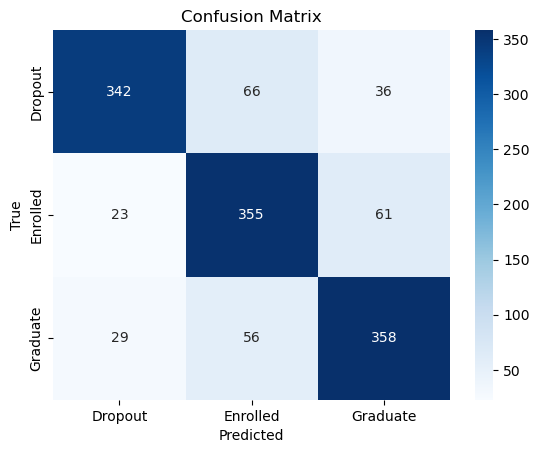

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dropout', 'Enrolled', 'Graduate'], yticklabels=['Dropout', 'Enrolled', 'Graduate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()